## Семинар 9: "LSTM"[SOLVED]

ФИО: Константиновский Борис Олегович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class Logit(nn.Module):
    def __init__(self, input_size, output_size, sig='Sigmoid'):
        super(Logit, self).__init__()
        self.lin = nn.Linear(input_size, output_size, bias=True)
        if sig == 'Sigmoid':
            self.sig = nn.Sigmoid()
        elif sig == 'Tanh':
            self.sig = nn.Tanh()
    def forward(self, x):
        x = self.lin(x)
        x = self.sig(x)
        return x
    
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(MyLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.W_f = Logit(input_size+hidden_size, hidden_size)
        self.W_i = Logit(input_size+hidden_size, hidden_size)
        self.W_o = Logit(input_size+hidden_size, hidden_size)
        self.W_c = Logit(input_size+hidden_size, hidden_size, 'Tanh')
        
        self.tanh = nn.Tanh()
        self.init_hidden()
        
    def init_hidden(self):
        self.c = Variable(torch.randn(1,self.hidden_size))
        self.h = Variable(torch.randn(1,self.hidden_size))
        
    
        
    def forward(self, x):
        
        ret = []
        x_size = x.size()[2]
        b_size = x.size()[1]
        x_len = x.size()[0]
        
        for j in range(b_size):
            self.init_hidden()    
            res = []
            b = x.narrow(1, j, 1)
            
            for i in range(x_len):
                _x = b.narrow(0, i, 1).view(1, x_size)
                _x = torch.cat([_x, self.h], dim=1)
                f = self.W_f(_x)
                i = self.W_i(_x)
                c = self.W_c(_x)
                o = self.W_o(_x)

                self.c = f * self.c + i * c
                self.h = o * self.tanh(self.c)
                res.append(self.h.view(1, 1, self.hidden_size))
            ret.append(torch.cat(res, dim=0))
        ret = torch.cat(ret, dim=1)
            
        return ret

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

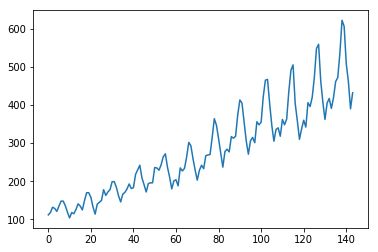

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print("   ", len(train), len(test))


    96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [7]:
# Пример подготовленных данных

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

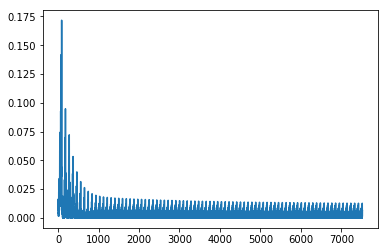

In [20]:
model = nn.LSTM(input_size=look_back, hidden_size=1, bias=True, num_layers=1)
#clf = nn.Linear(1,1, bias=True)
loss_fn = nn.MSELoss()
losses = []
#opt = torch.optim.Adam(chain(model.parameters(),clf.parameters()), lr=0.001)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
#h = (Variable(torch.randn(1,1,1)), Variable(torch.randn(1,1,1)))
for epoch in range(80):
    for i in range(trainY.shape[0]):
        x = Variable(torch.FloatTensor(trainX[i:i+1]))
        y = Variable(torch.FloatTensor(np.array(trainY[i:i+1])))

        y_pred, _ = model(x)
        #y_pred = clf(y_pred.view(1,1)).view(1,1,1)
        #print(h[0].data.numpy().shape)
        #print("    ", np.squeeze(y_pred).reshape(1), y)
        loss = loss_fn(np.squeeze(y_pred).reshape(1), y)
        losses.append(loss.data.numpy())
        opt.zero_grad()
        loss.backward()
        opt.step()
plt.plot(losses)
plt.show()

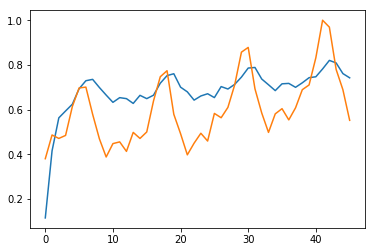

In [22]:
pred = []
h = (Variable(torch.randn(1,1,1)), Variable(torch.randn(1,1,1)))
for i in range(testY.shape[0]):
    x = Variable(torch.FloatTensor(testX[i:i+1]))
    y_pred, h = model(x, h)
    #y_pred = clf(y_pred.view(1,1))
    pred.append(y_pred.data.numpy()[0])
pred = np.array(pred).reshape(-1)
plt.plot(pred)
plt.plot(testY)
plt.show()

In [23]:
# Пример подготовленных данных

look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

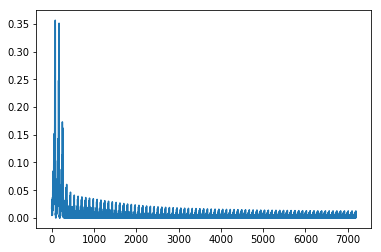

In [24]:
model = nn.LSTM(input_size=look_back, hidden_size=1, bias=True, num_layers=1)
#clf = nn.Linear(1,1, bias=True)
loss_fn = nn.MSELoss()
losses = []
#opt = torch.optim.Adam(chain(model.parameters(),clf.parameters()), lr=0.001)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
#h = (Variable(torch.randn(1,1,1)), Variable(torch.randn(1,1,1)))
for epoch in range(80):
    for i in range(trainY.shape[0]):
        x = Variable(torch.FloatTensor(trainX[i:i+1]))
        y = Variable(torch.FloatTensor(np.array(trainY[i:i+1])))

        y_pred, _ = model(x)
        #y_pred = clf(y_pred.view(1,1)).view(1,1,1)
        #print(h[0].data.numpy().shape)
        #print("    ", np.squeeze(y_pred).reshape(1), y)
        loss = loss_fn(np.squeeze(y_pred).reshape(1), y)
        losses.append(loss.data.numpy())
        opt.zero_grad()
        loss.backward()
        opt.step()
plt.plot(losses)
plt.show()

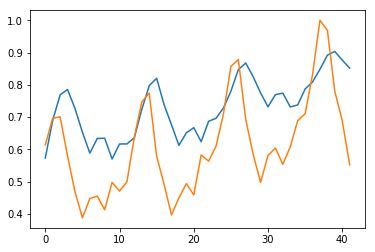

In [25]:
pred = []
h = (Variable(torch.randn(1,1,1)), Variable(torch.randn(1,1,1)))
for i in range(testY.shape[0]):
    x = Variable(torch.FloatTensor(testX[i:i+1]))
    y_pred, h = model(x, h)
    #y_pred = clf(y_pred.view(1,1))
    pred.append(y_pred.data.numpy()[0])
pred = np.array(pred).reshape(-1)
plt.plot(pred)
plt.plot(testY)
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: